In [1]:
%load_ext autoreload
%autoreload 2

import cPickle as pickle
import os; import sys; sys.path.append('..'); sys.path.append('../gp/')
import gp
import gp.nets as nets

from nolearn.lasagne.visualize import plot_loss
from nolearn.lasagne.visualize import plot_conv_weights
from nolearn.lasagne.visualize import plot_conv_activity
from nolearn.lasagne.visualize import plot_occlusion

from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, precision_recall_fscore_support, f1_score, precision_recall_curve, average_precision_score, zero_one_loss


from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

%matplotlib inline

/home/d/nolearn/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using gpu device 0: GeForce GTX TITAN (CNMeM is disabled, CuDNN 4007)
/home/d/nolearn/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
NETS = []
NETS.append('../nets/IPMLB_FULL.p') # image + prob + binary + large border

network_path = NETS[-1]

with open(network_path, 'rb') as f:
    net = pickle.load(f)

In [17]:
p = net.get_all_params()

In [42]:
X_test, y_test = gp.Patch.load_rgba_test_only('ipmlb')

Loaded /home/d/patches//ipmlb/ in 0.0836169719696 seconds.


In [39]:
net.layers_

Layers([('input', <lasagne.layers.input.InputLayer at 0x7fbd5afc7710>),
        ('conv1', <lasagne.layers.conv.Conv2DLayer at 0x7fbd5afc7290>),
        ('pool1', <lasagne.layers.pool.MaxPool2DLayer at 0x7fbd2d2b9890>),
        ('dropout1', <lasagne.layers.noise.DropoutLayer at 0x7fbd2d2b98d0>),
        ('conv2', <lasagne.layers.conv.Conv2DLayer at 0x7fbd2d2d1dd0>),
        ('pool2', <lasagne.layers.pool.MaxPool2DLayer at 0x7fbd2d2e1090>),
        ('dropout2', <lasagne.layers.noise.DropoutLayer at 0x7fbd2d2e10d0>),
        ('conv3', <lasagne.layers.conv.Conv2DLayer at 0x7fbd2c5d20d0>),
        ('pool3', <lasagne.layers.pool.MaxPool2DLayer at 0x7fbd2c5d2350>),
        ('dropout3', <lasagne.layers.noise.DropoutLayer at 0x7fbd2c5d2390>),
        ('conv4', <lasagne.layers.conv.Conv2DLayer at 0x7fbd2c577110>),
        ('pool4', <lasagne.layers.pool.MaxPool2DLayer at 0x7fbd2c577390>),
        ('dropout4', <lasagne.layers.noise.DropoutLayer at 0x7fbd2c5773d0>),
        ('hidden5', <lasagne.lay

In [47]:
X_test[0][0].shape

(75, 75)

In [59]:
import theano
import theano.tensor as T
from lasagne.layers import get_output

In [63]:
x = X_test[100].reshape(1,4,75,75)
layer = net.layers_['hidden5']
xs = T.tensor4('xs').astype(theano.config.floatX)
get_activity = theano.function([xs], get_output(layer, xs))

activity = get_activity(x)

In [62]:
activity

array([[ 0.19787416,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [64]:
activity

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  2.09685564,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

KeyboardInterrupt: 

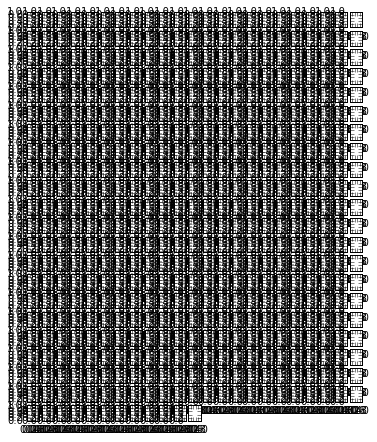

In [51]:
plot_conv_activity(net.layers_['hidden5'], X_test[0].reshape(1,4,75,75))

In [2]:
# load cremi A data
import h5py
import mahotas as mh
import numpy as np
import tifffile as tif

In [3]:
input_image = np.zeros((125,1250,1250))
input_rhoana = np.zeros((125,1250,1250), dtype=np.uint64)
input_gold = np.zeros((125,1250,1250), dtype=np.uint64)
input_prob = np.zeros((125,1250,1250))

for z in range(125):
    image, prob, gold, rhoana = gp.Cremi.read_section('/home/d/data/CREMI/C/', z)
    input_image[z] = image
    input_prob[z] = prob
    input_gold[z] = gold
    input_rhoana[z] = rhoana

Loading 000000000_000000000_000000000_image.png
Loading 000000000_000000000_000000001_image.png
Loading 000000000_000000000_000000002_image.png
Loading 000000000_000000000_000000003_image.png
Loading 000000000_000000000_000000004_image.png
Loading 000000000_000000000_000000005_image.png
Loading 000000000_000000000_000000006_image.png
Loading 000000000_000000000_000000007_image.png
Loading 000000000_000000000_000000008_image.png
Loading 000000000_000000000_000000009_image.png
Loading 000000000_000000000_000000010_image.png
Loading 000000000_000000000_000000011_image.png
Loading 000000000_000000000_000000012_image.png
Loading 000000000_000000000_000000013_image.png
Loading 000000000_000000000_000000014_image.png
Loading 000000000_000000000_000000015_image.png
Loading 000000000_000000000_000000016_image.png
Loading 000000000_000000000_000000017_image.png
Loading 000000000_000000000_000000018_image.png
Loading 000000000_000000000_000000019_image.png
Loading 000000000_000000000_000000020_im

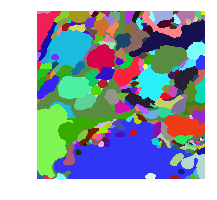

In [5]:
gp.Util.view(gold)

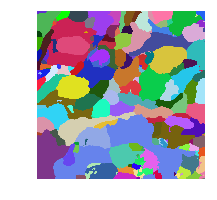

In [6]:
gp.Util.view(rhoana)

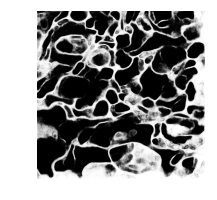

In [7]:
gp.Util.view(prob, color=False)

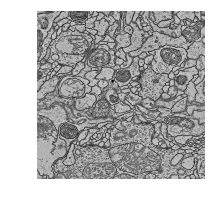

In [8]:
gp.Util.view(image, color=False)

In [9]:
gp.Util.vi(input_rhoana, input_gold)

2.032825794062817

In [10]:
gp.metrics.adapted_rand(input_rhoana, input_gold)

0.58514442753365858

In [11]:
net.uuid = 'IPMLB'
bigM_cremiB = gp.Legacy.create_bigM_without_mask(net, input_image, input_prob, input_rhoana, verbose=True)

1648 generated in 32.1830060482 seconds.
Grouped into 296 patches in 0.00803518295288 seconds.
1760 generated in 37.3747820854 seconds.
Grouped into 305 patches in 0.0077919960022 seconds.


In [12]:
bigM_cA_after_95, out_cA_volume_after_auto_95, cA_auto_fixes_95, cA_auto_vi_s_95 = gp.Legacy.splits_global_from_M_automatic(net, 
                                                                                                                            bigM_cremiB, 
                                                                                                                            input_image, 
                                                                                                                            input_prob, 
                                                                                                                            input_rhoana,
                                                                                                                            input_gold, 
                                                                                                                            sureness_threshold=.95)


In [13]:
gp.Util.vi(out_cA_volume_after_auto_95, input_gold)

2.9363190425761205

In [14]:
gp.metrics.adapted_rand(out_cA_volume_after_auto_95, input_gold)

0.77019023534857156

In [15]:
cA_auto_fixes_95

[(0, 0.99999666213989258),
 (0, 0.99998331069946289),
 (0, 0.99997556209564209),
 (0, 0.99996280670166016),
 (1, 0.9999578595161438),
 (0, 0.99995410442352295),
 (1, 0.99993646144866943),
 (0, 0.999930739402771),
 (1, 0.99991261959075928),
 (1, 0.99991154670715332),
 (1, 0.99995994567871094),
 (0, 0.99990248680114746),
 (0, 0.99984288215637207),
 (1, 0.99984192848205566),
 (0, 0.99983119964599609),
 (0, 0.99978169798851013),
 (0, 0.99977171421051025),
 (0, 0.99974232912063599),
 (0, 0.99972695112228394),
 (0, 0.99972623586654663),
 (1, 0.99968212842941284),
 (0, 0.99967628717422485),
 (0, 0.99961256980895996),
 (0, 0.99960362911224365),
 (0, 0.99972695112228394),
 (1, 0.99953120946884155),
 (1, 0.99950551986694336),
 (1, 0.99963210060069563),
 (0, 0.9993402361869812),
 (0, 0.99932390451431274),
 (1, 0.99922299385070801),
 (0, 0.99921345710754395),
 (1, 0.99920111894607544),
 (0, 0.99915897846221924),
 (0, 0.99927312135696411),
 (1, 0.99912625551223755),
 (1, 0.99892324209213257),
 (0, 

In [4]:
ar = []
for z in range(input_rhoana.shape[0]):
    ar.append(gp.metrics.adapted_rand(input_rhoana[z], input_gold[z]))

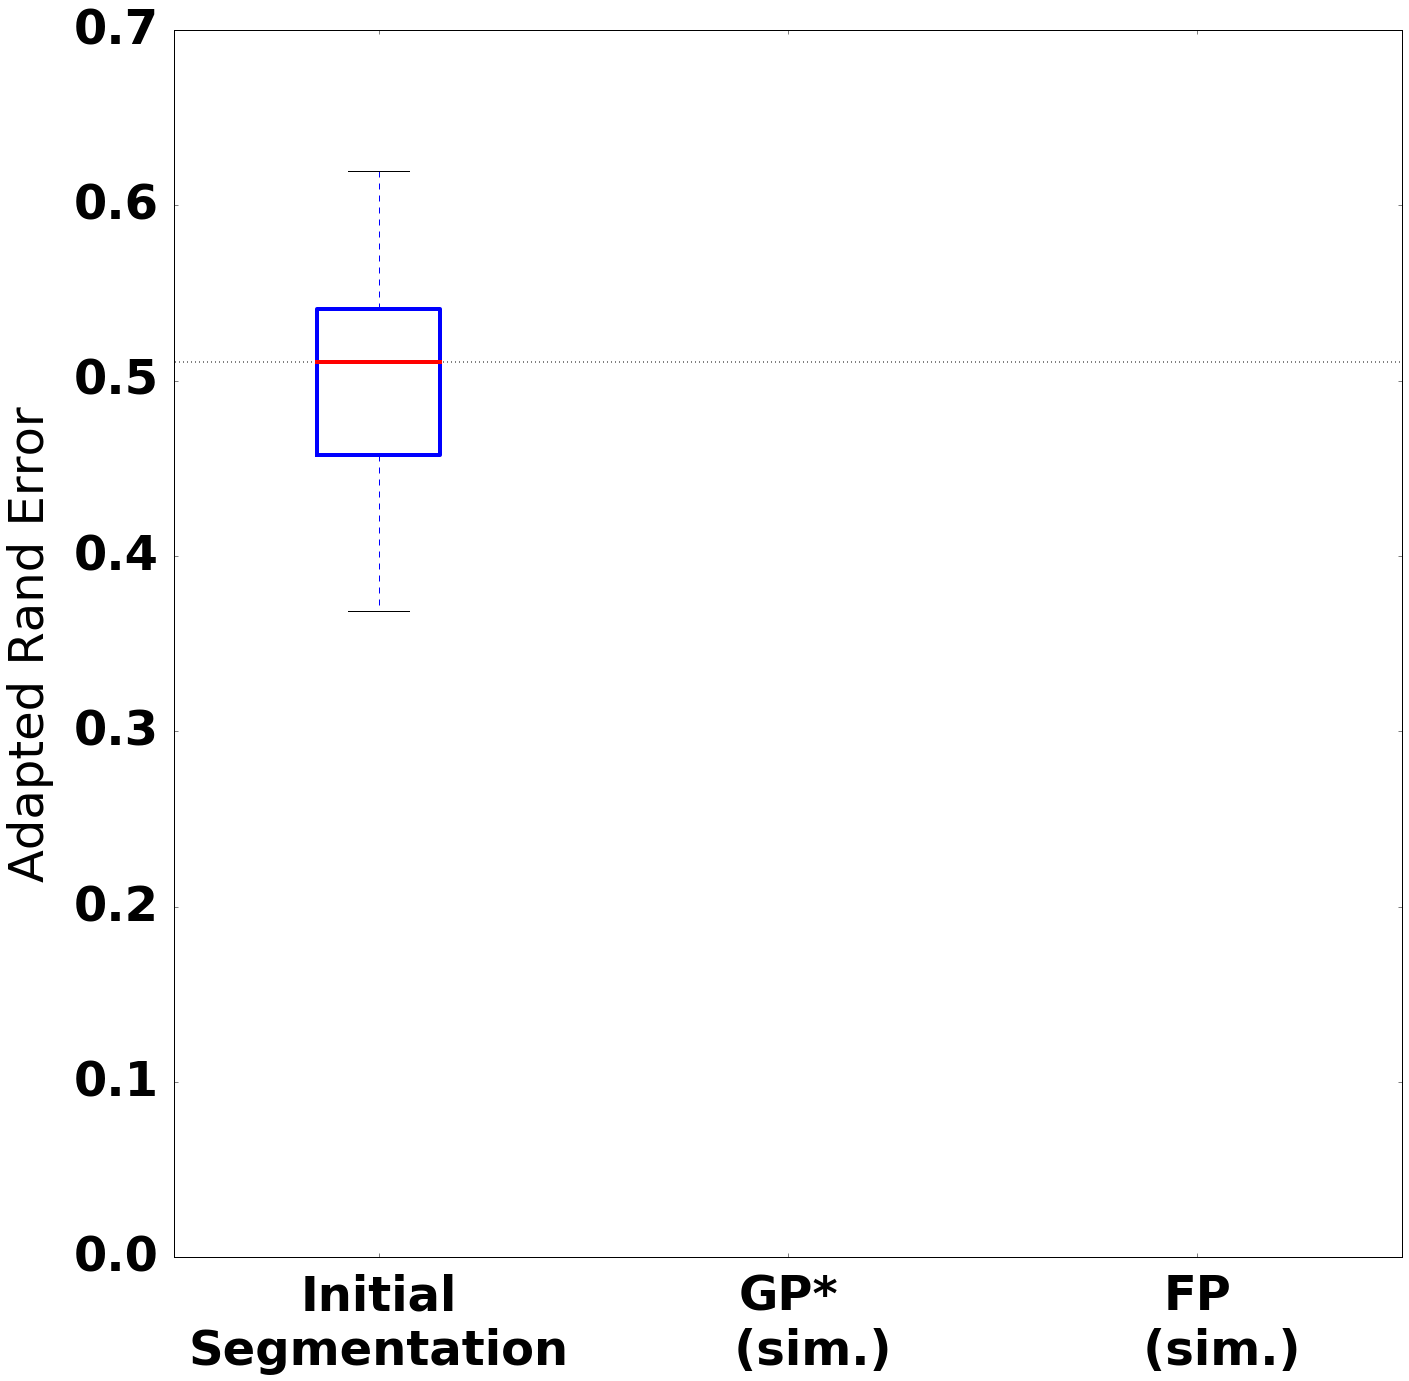

In [8]:
data = collections.OrderedDict()
data['Initial\nSegmentation'] = ar
data['GP*\n   (sim.)'] = []#cylinder_sim_user_vi_s[-1]
# data['GP*\n   (sim.)'] = []#[v - 0.1 for v in dojo_vi_95[2]]
data['FP\n   (sim.)'] = []#dojo_vi_95[2]

gp.Legacy.plot_arand(data, '/tmp/cremi.pdf')#, output_folder+'/dojo_vi.pdf')

In [6]:
import collections